In [17]:
from functools import reduce
import re

In [210]:
# wikitext parser installing

!pip install mwparserfromhell

     |████████████████████████████████| 143kB 1.0MB/s eta 0:00:01
  Stored in directory: /Users/vaden4d/Library/Caches/pip/wheels/2a/76/d5/7088b941df3b362c45dd7912dd05314bc034751ec9cbca9a75
Successfully built mwparserfromhell


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH_TO_SPARK = '../../spark/spark-2.4.3-bin-hadoop2.7'

In [3]:
import findspark
findspark.init(PATH_TO_SPARK)
from pyspark.sql import SparkSession
import pyspark
spark = SparkSession.builder.getOrCreate()

In [131]:
from pyspark.sql import *
from pyspark.sql.functions import col, lower, regexp_replace, split, size, UserDefinedFunction
from pyspark.sql.types import StringType, IntegerType

from pyspark.ml.feature import VectorAssembler

In [5]:
import numpy as np
import pandas as pd

## Data preprocessing

In [6]:
# df_path = "../csv_data/top-10-sample-output.csv"
df_path = "../csv_data/sample-output.csv"
df = spark.read.csv(df_path, inferSchema=True, header=True, multiLine=True, escape='"')
#pdf = pd.read_csv(df_path, index_col=0)

In [194]:
df.show(3)

+---+--------------------+-----------+-----------+---------+--------------------+--------+---+---------+------------+----------+--------------------+--------------------+-------------------+-----------+---------+
|_c0|             comment|contributor|     format|       id|                  ip|   model| ns| parentid|restrictions|  revision|                sha1|                text|          timestamp|      title| username|
+---+--------------------+-----------+-----------+---------+--------------------+--------+---+---------+------------+----------+--------------------+--------------------+-------------------+-----------+---------+
|  0|/* Main character...|           |text/x-wiki|891988700|        100.0.126.88|wikitext|  0|891441652|        null|          |5ib24sew99ceyko33...|{{About|the telev...|2019-04-11 16:19:39|The X-Files|     null|
|  1|Reverted edits by...|           |text/x-wiki| 31009372|                null|wikitext|  0|894129318|        null|          |q2nngvea32gwowk9y...

In [7]:
"""
Filtering columns
    Useful: sha1 (as identifier),  timestamp, title, text
    Questionable: user, comment, ip, id (there are different articles with the same id), parentid, restrictions
    Not useful (no unique info): model, format, ns, contributor, revision, restrictions
""" 

print("All columns:", df.columns)
print("Unique values for..")
for column in ["format", "model", "ns", "contributor", "revision", "restrictions"]:
    print("\t", column, ":", df.select(column).distinct())
    
useful_columns = ["sha1", "timestamp", "title", "text"]
print("Useful columns:", useful_columns)

clean_df = df[useful_columns]
#clean_pdf = pdf[useful_columns]

All columns: ['_c0', 'comment', 'contributor', 'format', 'id', 'ip', 'model', 'ns', 'parentid', 'restrictions', 'revision', 'sha1', 'text', 'timestamp', 'title', 'username']
Unique values for..
	 format : DataFrame[format: string]
	 model : DataFrame[model: string]
	 ns : DataFrame[ns: int]
	 contributor : DataFrame[contributor: string]
	 revision : DataFrame[revision: string]
	 restrictions : DataFrame[restrictions: string]
Useful columns: ['sha1', 'timestamp', 'title', 'text']


In [8]:
clean_df.show(10)

+--------------------+-------------------+--------------------+--------------------+
|                sha1|          timestamp|               title|                text|
+--------------------+-------------------+--------------------+--------------------+
|5ib24sew99ceyko33...|2019-04-11 16:19:39|         The X-Files|{{About|the telev...|
|q2nngvea32gwowk9y...|2019-04-25 23:53:46|         Third World|{{mergefrom|Third...|
|ihx6i3puongpsv8n4...|2019-04-21 05:46:04|          Twin Peaks|{{About|the TV se...|
|s8aob488ldyo67vob...|2019-04-25 14:51:44|            Thallium|{{distinguish|Thu...|
|shlofsuzadp1u74w3...|2019-04-23 09:54:24|         Text editor|{{selfref|For the...|
|f1x0xk50c6f0kefod...|2019-04-10 22:04:07|        Tennis court|{{About|the sport...|
|9q70kcncd12befu48...|2019-04-15 02:18:54|The Communist Man...|{{refimprove|date...|
|4jmuyzuyosip9r35x...|2019-04-14 01:08:59|               Trier|{{short descripti...|
|ge2818x0ko9adp8ei...|2019-04-21 13:23:13|                 Ton|{{

In [197]:
clean_df.printSchema()
print("Size of the DataFrame: {} records".format(clean_df.count()))

root
 |-- sha1: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)

Size of the DataFrame: 38842 records


## Feature engineering

In [256]:
"""
Headings counting
Syntaxis:
    ==Level 2==
    ===Level 3===
    ====Level 4====
    =====Level 5=====
    ======Level 6======
"""

def single_head_level_count(text, level):
    assert level in range(2,7)
    pattern = "=" * level
    pattern = pattern + "[a-zA-Z0-9.,!? ]+" + pattern
    return size(split(text, pattern=pattern))-1

def count_headings(df):
    return reduce(
        lambda df, level: df.withColumn("level{}".format(level),
                                        single_head_level_count(col("text"), level)),
        range(2, 7), df)
    
count_headings(clean_df).show(20)

+--------------------+-------------------+--------------------+--------------------+------+------+------+------+------+
|                sha1|          timestamp|               title|                text|level2|level3|level4|level5|level6|
+--------------------+-------------------+--------------------+--------------------+------+------+------+------+------+
|5ib24sew99ceyko33...|2019-04-11 16:19:39|         The X-Files|{{About|the telev...|    34|    26|     5|     0|     0|
|q2nngvea32gwowk9y...|2019-04-25 23:53:46|         Third World|{{mergefrom|Third...|    10|     0|     0|     0|     0|
|ihx6i3puongpsv8n4...|2019-04-21 05:46:04|          Twin Peaks|{{About|the TV se...|    24|    14|     0|     0|     0|
|s8aob488ldyo67vob...|2019-04-25 14:51:44|            Thallium|{{distinguish|Thu...|    18|     8|     1|     0|     0|
|shlofsuzadp1u74w3...|2019-04-23 09:54:24|         Text editor|{{selfref|For the...|    10|     0|     0|     0|     0|
|f1x0xk50c6f0kefod...|2019-04-10 22:04:0

In [325]:
'''Internal Links:
    [[A]] -- internal reference to an article titled A
    [[A|B]] -- internal reference to an article titled A (written as B)
    [[A#C|B]] -- internal reference to a section C of an article titled A (written as B)'''

def count_internal_links(df):
    
    pattern = "\[\[[a-zA-Z0-9.,!? ]+\]\]"
    pattern += "|\[\[[a-zA-Z0-9.,!? ]+\|[a-zA-Z0-9.,!? ]+\]\]"
    pattern += "|\[\[[a-zA-Z0-9.,!? ]+#[a-zA-Z0-9.,!? ]+\|[a-zA-Z0-9.,!? ]+\]\]"
    
    return df.withColumn("n_internal_links",
                         size(split(col('text'), pattern=pattern))-1)

In [355]:
'''External Links:
    https://www.google.com -- simple link
    [https://www.google.com] -- link (reference)
    [https://www.google.com A] -- reference written as A
    <ref name="B">[https://www.google.com A]</ref> -- reference A written as B, can be referenced again like:
    <ref name="B" /> -- reference to the source B
    <ref>Lots of words</ref> -- reference without a link
    {{sfnm|1a1=Craig|1y=2005|1p=14|2a1=Sheehan|2y=2003|2p=85}} -- external reference
    Example:
        {{sfnm|1a1=McLaughlin|1y=2007|1p=59|2a1=Flint|2y=2009|2p=27}} -- McLaughlin 2007, p. 59; Flint 2009, p. 27.
        {{sfnm|1a1=Craig|1y=2005|1p=14|2a1=Sheehan|2y=2003|2p=85}} -- Craig 2005, p. 14; Sheehan 2003, p. 85.'''

def count_external_links(df):
    
    pattern = 'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+'
    pattern += '|\[https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+\]'
    pattern += '|\[https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+\ [a-zA-Z0-9.,!? ]+]'
    pattern += '<ref name="[a-zA-Z0-9.,!? ]+">\[https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+\]'
    
    # template of the external reference
    #template = '\{\{sfnm\|1a1=[a-zA-Z]+\|1y=[0-9]+\|1p=[0-9]+\|2a1=[a-zA-Z]+\|2y=[0-9]+\|2p=[0-9]+\}\}'
    
    # <ref name="B" /> - this form use information from other reference, so we didn't count it again
    # <ref>Lots of words</ref> - reference without a link will be in the other feature
    
    return df.withColumn("n_external_links",
                         size(split(col('text'), pattern=pattern))-1)

In [103]:
def count_paragraphs(df):
    
    # filter the basic wikipedia syntaxis
    pattern_filtering = '\n\n\{\{.*\}\}\n\n|\n\n\[\[.*\]\]\n\n|\n\n={1,7}.*={1,7}\n\n'
    # split by two enters
    pattern_splitting = '\n\n'

    return df.withColumn('n_paragraphs', size(split(regexp_replace(col('text'), 
                                                                   pattern_filtering, ''), 
                                                    pattern_splitting))-1)

In [111]:
'''<ref>Lots of words</ref> -- reference without a link
{{cn}} -- citation needed'''

def count_unreferenced(df):
    
    # citation needed and references without link
    pattern = '\{\{cn\}\}|<ref>[a-zA-Z0-9.,!? ]+</ref>'
    
    return df.withColumn('n_unreferenced', size(split(col('text'), pattern))-1)

In [132]:
'''[[Category:Category name]]
[[:Category:Category name]]
[[:File:File name]]'''

def count_categories(df):
    
    #using template
    pattern = '\[\[:?Category:[a-zA-Z0-9.,\-!?\(\) ]+\]\]'
    
    return df.withColumn('n_categories', size(split(col('text'), pattern))-1)

In [133]:
count_categories(clean_df.limit(4)).show()

+--------------------+-------------------+-----------+--------------------+------------+
|                sha1|          timestamp|      title|                text|n_categories|
+--------------------+-------------------+-----------+--------------------+------------+
|5ib24sew99ceyko33...|2019-04-11 16:19:39|The X-Files|{{About|the telev...|          40|
|q2nngvea32gwowk9y...|2019-04-25 23:53:46|Third World|{{mergefrom|Third...|           6|
|ihx6i3puongpsv8n4...|2019-04-21 05:46:04| Twin Peaks|{{About|the TV se...|          53|
|s8aob488ldyo67vob...|2019-04-25 14:51:44|   Thallium|{{distinguish|Thu...|           2|
+--------------------+-------------------+-----------+--------------------+------------+



## Clustering 

In [7]:
#from sklearn import datasets
#data = datasets.load_iris()
#data = pd.DataFrame(np.c_[data['data'], data['target']])
#data.to_csv('iris.csv', index=False)

In [92]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import PCA

In [182]:
dataset = spark.read.csv('../csv_data/iris.csv', inferSchema=True, header=True, multiLine=True, escape='"')
dataset.show(10)

+---+---+---+---+---+
|  0|  1|  2|  3|  4|
+---+---+---+---+---+
|5.1|3.5|1.4|0.2|0.0|
|4.9|3.0|1.4|0.2|0.0|
|4.7|3.2|1.3|0.2|0.0|
|4.6|3.1|1.5|0.2|0.0|
|5.0|3.6|1.4|0.2|0.0|
|5.4|3.9|1.7|0.4|0.0|
|4.6|3.4|1.4|0.3|0.0|
|5.0|3.4|1.5|0.2|0.0|
|4.4|2.9|1.4|0.2|0.0|
|4.9|3.1|1.5|0.1|0.0|
+---+---+---+---+---+
only showing top 10 rows



In [183]:
for i in range(4):
    dataset = dataset.withColumnRenamed(str(i), 'features_'+str(i))
dataset = dataset.withColumnRenamed('4', 'labels')

features = dataset[['features_0', 'features_1', 'features_2', 'features_3']]
labels = dataset['labels']

In [184]:
# vectorize features into single row with type Vector
vectorAssembler = VectorAssembler(inputCols=['features_0', 'features_1', 'features_2', 'features_3'],
                                  outputCol="features")
features = vectorAssembler.transform(features)

In [185]:
features.show(4)

+----------+----------+----------+----------+-----------------+
|features_0|features_1|features_2|features_3|         features|
+----------+----------+----------+----------+-----------------+
|       5.1|       3.5|       1.4|       0.2|[5.1,3.5,1.4,0.2]|
|       4.9|       3.0|       1.4|       0.2|[4.9,3.0,1.4,0.2]|
|       4.7|       3.2|       1.3|       0.2|[4.7,3.2,1.3,0.2]|
|       4.6|       3.1|       1.5|       0.2|[4.6,3.1,1.5,0.2]|
+----------+----------+----------+----------+-----------------+
only showing top 4 rows



In [186]:
# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(3).setSeed(1)
model = bkm.fit(features)

# Evaluate clustering.
cost = model.computeCost(features)
print("Within Set Sum of Squared Errors = " + str(cost))

# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 84.20375254574043
Cluster Centers: 
[5.00566038 3.36981132 1.56037736 0.29056604]
[5.94745763 2.76610169 4.45423729 1.45423729]
[6.85       3.07368421 5.74210526 2.07105263]


In [187]:
#get predictions and collect into the list
labels = model.transform(features).select('prediction')
labels = labels.collect() 
#create vanilla list with ints 
# instead of list with element type Rows
labels = list(map(lambda x: x.prediction, labels))

## PCA compressing

In [189]:
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features)

compressed = model.transform(features).select("pcaFeatures")
compressed.show(truncate=False)

+-----------------------------------------+
|pcaFeatures                              |
+-----------------------------------------+
|[-2.818239506639473,-5.646349823412762]  |
|[-2.7882234453146832,-5.149951351762869] |
|[-2.613374563549713,-5.182003150742105]  |
|[-2.757022276967599,-5.008653597575749]  |
|[-2.77364859605448,-5.653707089762587]   |
|[-3.2215054997645174,-6.068283025890586] |
|[-2.681827381868401,-5.237491192299108]  |
|[-2.8762201594623766,-5.49033753652599]  |
|[-2.615982400828456,-4.74864082264096]   |
|[-2.8296093347880547,-5.213178330953537] |
|[-2.995418041957154,-5.972021475476232]  |
|[-2.889609901700287,-5.341682515989045]  |
|[-2.7162558664209913,-5.091840576625933] |
|[-2.2785613887433565,-4.815557989821284] |
|[-2.8576147426669802,-6.505717213265226] |
|[-3.116326099077877,-6.665014907228327]  |
|[-2.8788372573845833,-6.137632091008922] |
|[-2.854068426354628,-5.638801721421016]  |
|[-3.3025448089914295,-6.1997916157898665]|
|[-2.914378732730242,-5.84051288

In [190]:
compressed = compressed.toPandas()
compressed.pcaFeatures = compressed.pcaFeatures.apply(lambda x: np.array(x))
compressed = compressed.pcaFeatures.values
compressed = np.stack(compressed, axis=0)

In [191]:
colors = {0: 'red', 1: 'green', 2: 'blue'}
colors = list(map(lambda x: colors[x], labels))

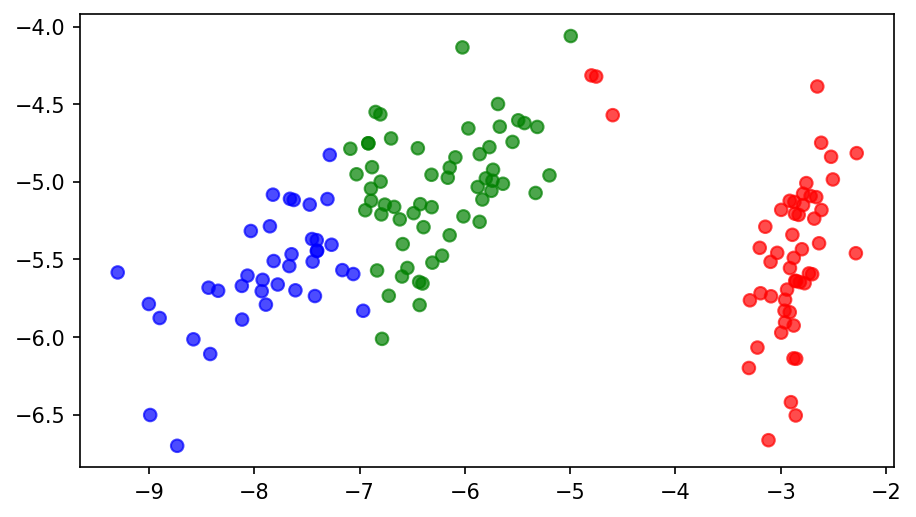

In [192]:
plt.figure(figsize=(7, 4), dpi=150)
plt.scatter(compressed[:, 0], compressed[:, 1], alpha=0.7, color=colors)